<a href="https://colab.research.google.com/github/nmach22/Promoter-Classification/blob/main/notebooks/train_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Env**

In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata
token = userdata.get('GITHUB_TOKEN')
user_name = userdata.get('GITHUB_USERNAME')
mail = userdata.get('GITHUB_MAIL')

!git config --global user.name "{user_name}"
!git config --global user.email "{mail}"
!git clone https://{token}@github.com/nmach22/Promoter-Classification.git
!pip install -r ./Promoter-Classification/requirements.txt


# **Imports**

In [37]:
# Imports
import sys
import os
import torch
import yaml
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the root directory of the cloned repository to the Python path
ROOT_DIR = '/content/Promoter-Classification'
sys.path.append(ROOT_DIR)


import importlib
import utils.fasta_dataset as dataset_module
import utils.encoding_functions as encoding_module
import utils.data_split as splitter_module
import models.transformer as transformer_module
import utils.train as train_module
import eval.train_evals as eval_module
import eval.metrics as metrics_module
importlib.reload(dataset_module)
importlib.reload(encoding_module)
importlib.reload(transformer_module)
importlib.reload(train_module)
importlib.reload(eval_module)
importlib.reload(metrics_module)
from utils.fasta_dataset import FastaDataset
from utils.encoding_functions import *
from models.transformer import DNATransformer
from utils.data_split import dataset_split
from utils.train import Train
from eval.train_evals import TrainEvals
from eval.metrics import *

with open(f"{ROOT_DIR}/config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

print(config.keys())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dict_keys(['data', 'dataset_split', 'train'])
cuda


# **Read Data**

In [43]:
ecoli_data = config['data']['bacillus']

prom_path = f"{ROOT_DIR}/{ecoli_data['promoter_fasta']}"
non_prom_path = f"{ROOT_DIR}/{ecoli_data['non_promoter_fasta']}"
seq_length = ecoli_data['seq_len']

dataset = FastaDataset(prom_path, non_prom_path, seq_len=seq_length,encoding_func=token_encode)

# **Split Data**

In [44]:
train_dataset, val_dataset, test_dataset = dataset_split(dataset)

# **Dataset Visualization**

In [45]:
save_dir = f"/content/drive/MyDrive/checkpoints_bio/transformer/{ecoli_data['name']}"

In [46]:
labels = [dataset[i][1].item() for i in range(len(train_dataset))]
label_counts = pd.Series(labels).value_counts().sort_index()
label_counts

# label_counts.index = ['Non-Promoter', 'Promoter']

# plt.figure(figsize=(6, 4))
# sns.barplot(x=label_counts.index, y=label_counts.values, palette=['skyblue', 'salmon'])
# plt.title(f'Class Distribution in {ecoli_data["name"]} Dataset')
# plt.ylabel('Count')

# os.makedirs(save_dir, exist_ok=True)
# save_path = os.path.join(save_dir, "class_dist")
# plt.savefig(save_path, bbox_inches='tight', dpi=300)

# plt.show()

# print("Class Distribution:")
# print(label_counts)

,count
0,588
1,373


# **Create Data Loaders**

In [26]:
batch_size = config['train']['batch_size']

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Train Model**

Epoch 1/100 | Train Loss: 0.5580 | Val Loss: 0.5245
  Train accuracy: 0.7284
  Val accuracy: 0.7317
  Train sensitivity: 0.0000
  Val sensitivity: 0.0000
  Train specificity: 1.0000
  Val specificity: 1.0000
  Train correlation_coef: 0.0000
  Val correlation_coef: 0.0000
Epoch 2/100 | Train Loss: 0.5288 | Val Loss: 0.4637
  Train accuracy: 0.7284
  Val accuracy: 0.7512
  Train sensitivity: 0.0000
  Val sensitivity: 0.0727
  Train specificity: 1.0000
  Val specificity: 1.0000
  Train correlation_coef: 0.0000
  Val correlation_coef: 0.2330
Epoch 3/100 | Train Loss: 0.4628 | Val Loss: 0.4275
  Train accuracy: 0.7700
  Val accuracy: 0.7659
  Train sensitivity: 0.2490
  Val sensitivity: 0.1273
  Train specificity: 0.9643
  Val specificity: 1.0000
  Train correlation_coef: 0.3257
  Val correlation_coef: 0.3105
Epoch 4/100 | Train Loss: 0.4314 | Val Loss: 0.3882
  Train accuracy: 0.7732
  Val accuracy: 0.8293
  Train sensitivity: 0.2261
  Val sensitivity: 0.4364
  Train specificity: 0.9771
  

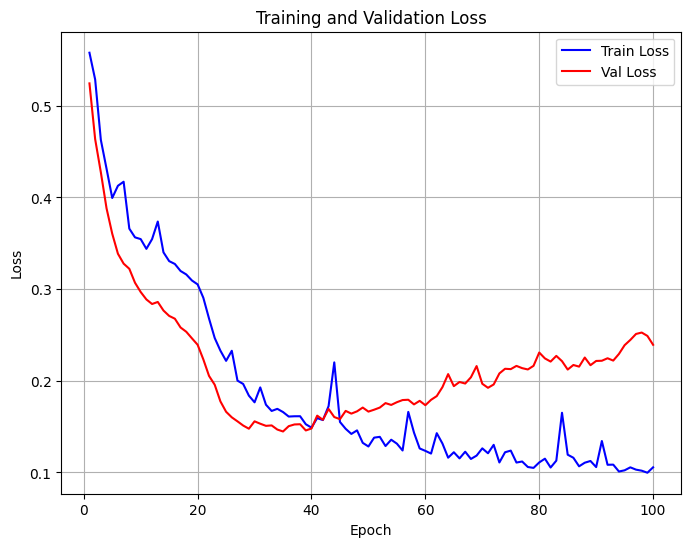

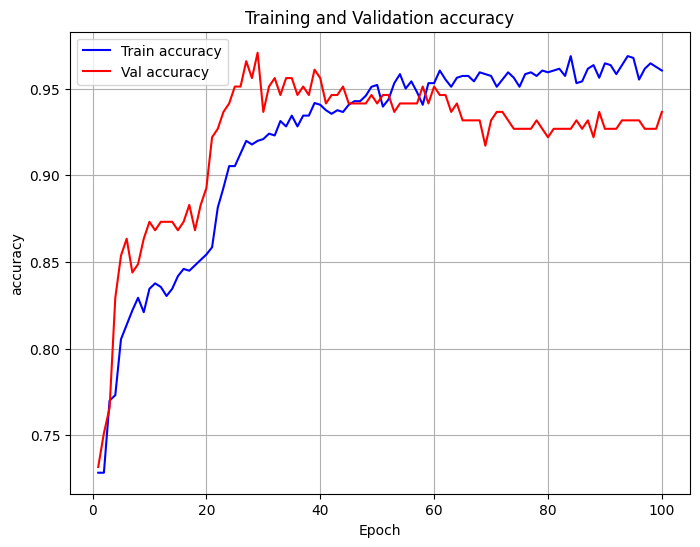

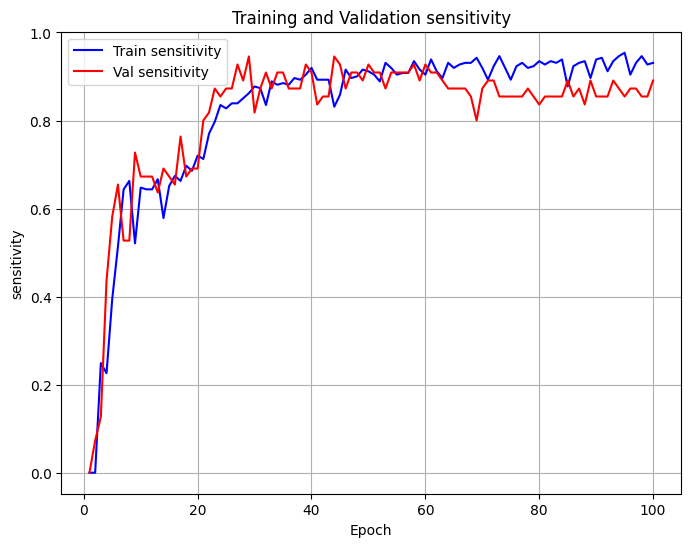

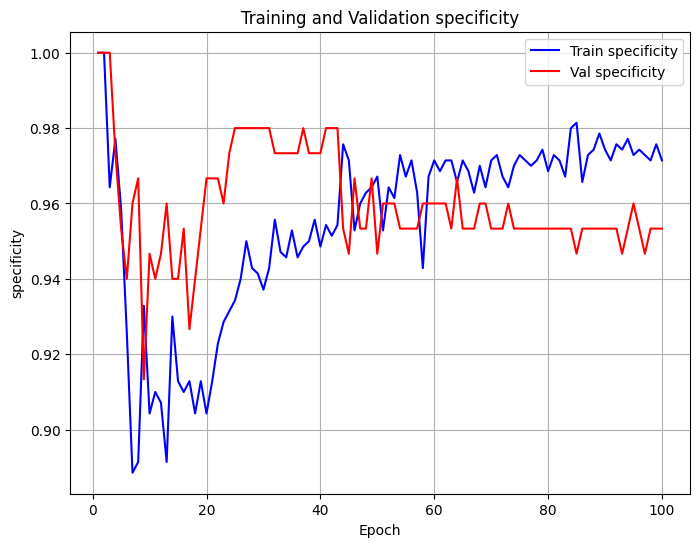

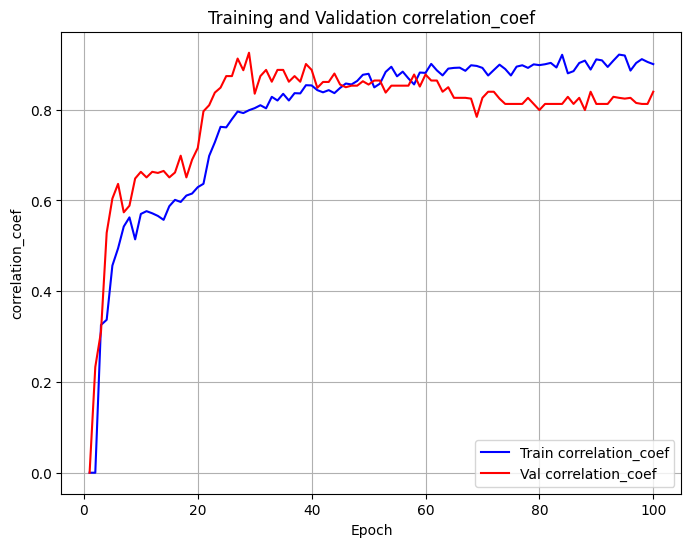

In [27]:
model = DNATransformer(seq_length,nhead=2,num_layers=1,dropout=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.BCELoss()

train = Train(model, train_loader,val_loader,optimizer,criterion,[TrainEvals()],device)
train.train(100,True)

# **Evaluation**

In [30]:
fpr, tpr, roc_auc, all_labels, all_predictions = calculate_roc_data(model,test_loader,False,device)

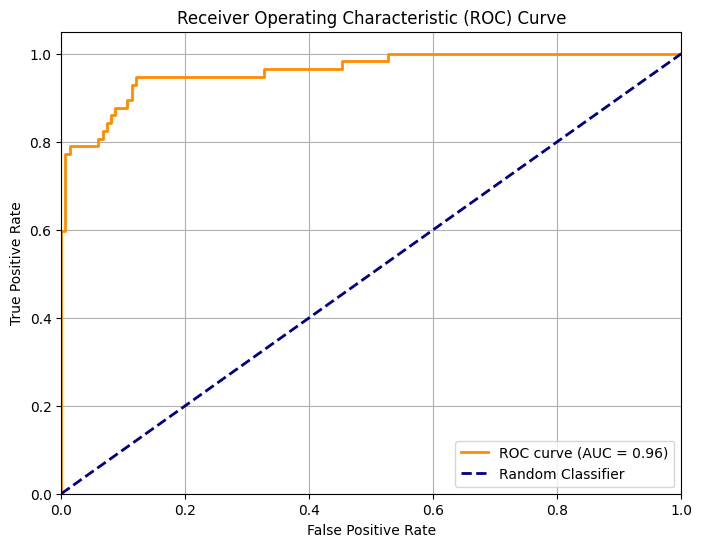

In [31]:
plot_roc_curve(fpr, tpr, roc_auc,save_dir=save_dir,
                file_name='bacillus_roc_curve'
               )

In [32]:
thresholds = np.linspace(0, 1, 100)

# Call the function to find the optimal threshold
optimal_threshold, max_f1_score = find_optimal_threshold(all_labels, all_predictions, thresholds)

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Maximum F1-score at optimal threshold: {max_f1_score:.4f}")

Optimal Threshold: 0.9495
Maximum F1-score at optimal threshold: 0.8654


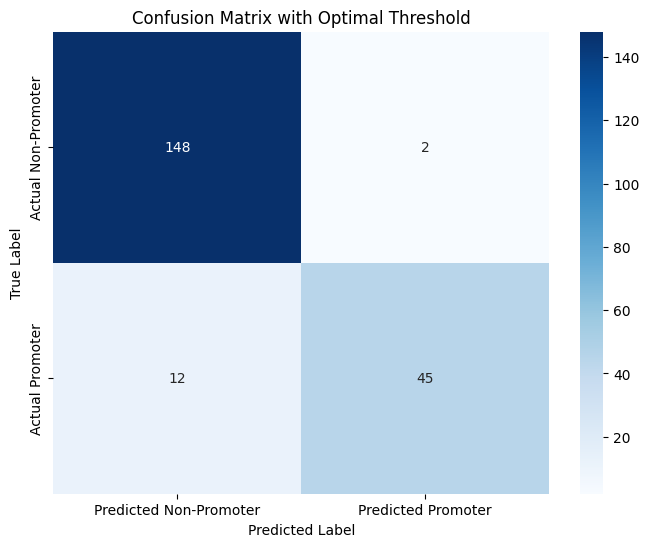

In [33]:

# Assuming optimal_threshold is already defined or will be defined next
# For now, let's plot with a default 0.5 or the previously calculated optimal_threshold if it exists
plot_confusion_matrix(all_labels, all_predictions, threshold=optimal_threshold, title='Confusion Matrix with Optimal Threshold',
                      save_dir=save_dir,
                      file_name='bacillus_confusion_matrix'
                      )

In [34]:

# Call the function to calculate and print metrics using the optimal_threshold
metrics_dict = calculate_metrics(all_labels, all_predictions, optimal_threshold)

print(f"Metrics at Optimal Threshold ({optimal_threshold:.4f}):")
for metric_name, value in metrics_dict.items():
    print(f"  {metric_name}: {value:.4f}")

Metrics at Optimal Threshold (0.9495):
  Accuracy: 0.9324
  Precision: 0.9574
  Recall (Sensitivity): 0.7895
  Negative Recall (Specificity): 0.9867
  F1-Score: 0.8654
  Correlation Coefficient (MCC): 0.8276


In [35]:

seq = dataset.sequences[0]

kmers = random_substitution_top_kmers(
    model,
    seq,
    encoding_func=token_encode,
    seq_len=81,
    window_size=7,
    top_k=10,
    device=device
)

for pos, kmer, score in kmers:
    print(f"Position {pos}: {kmer}  (importance={score:.4f})")

Position 54: TAAAGGG  (importance=0.9976)
Position 50: ACAATAA  (importance=0.9953)
Position 52: AATAAAG  (importance=0.9940)
Position 47: ACTACAA  (importance=0.9936)
Position 48: CTACAAT  (importance=0.9925)
Position 51: CAATAAA  (importance=0.9596)
Position 49: TACAATA  (importance=0.8330)
Position 46: GACTACA  (importance=0.6810)
Position 53: ATAAAGG  (importance=0.2876)
Position 45: TGACTAC  (importance=0.1698)


In [36]:

import json
import os
json_file_name = "bacillus_json"

# Prepare kmer data for JSON serialization (convert numpy types to native Python types)
kmer_data = [
    {
        "position": int(pos),
        "kmer": kmer,
        "importance": float(score)
    }
    for pos, kmer, score in kmers
]

# Prepare metrics data for JSON serialization (convert numpy types to native Python types)
# Ensure all values in metrics_dict are native Python types
metrics_serializable = {
    key: float(value) if isinstance(value, np.floating) else value
    for key, value in metrics_dict.items()
}

# Combine all data into a single dictionary
output_data = {
    "top_kmers": kmer_data,
    "metrics": metrics_serializable
}

# Define the full path for the JSON file
json_file_path = os.path.join(save_dir, f"{json_file_name}.json")

# Save the data to a JSON file
with open(json_file_path, 'w') as f:
    json.dump(output_data, f, indent=4)

print(f"Successfully saved top kmers and metrics to {json_file_path}")

Successfully saved top kmers and metrics to /content/drive/MyDrive/checkpoints_bio/transformer/Bacillus subtilis/bacillus_json.json
